In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import geemap
import os
import sklearn
import scipy
from scipy.stats import pearsonr
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy import stats

ee.Initialize()

def metrics(O, P):
    mae = sklearn.metrics.mean_absolute_error(O, P)
    mdae = sklearn.metrics.median_absolute_error(O, P)
    RSq = sklearn.metrics.r2_score(O, P)
    rmse = sklearn.metrics.mean_squared_error(O, P, squared=False)
    R2 = stats.linregress(O, P)[2]**2
    return mae, mdae, rmse, RSq, R2

# Plot regression. O = Observation and P = Prediction
def plot_regression(O, P):
    plt.figure(figsize = (6, 6))
#     plt.grid(zorder = 1)
    plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
    corr, _ = pearsonr(O, P)
    regmodel = LinearRegression()
    regmodel.fit(O.values.reshape(-1,1), P)
    rsq = regmodel.score(O.values.reshape(-1,1), P)
    obs, pred = O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1))
    plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
    plt.plot([-5, obs.max()], [-5, obs.max()], color = 'navy', ls = '--', zorder = 1)
    plt.legend([u'Pearson R\u00b2: {:.3f}'.format(corr**2), '1:1 Plot', 'Observed - Predicted'], loc = 2)
    plt.xlabel('In situ Precipitation [mm/month]')
    plt.ylabel('Satelite Precipitation [mm/month]')
    stats = np.round(metrics(O, P), 3)
    stats = pd.DataFrame(data = stats, index = ['MAE', 'MDAE', 'RMSE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
    stats.loc['RSq'] = np.round((stats.loc['RSq']) , 2) * 100
    stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']) , 2) * 100
    stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm/d' )
    stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
    stats = stats2.append(stats3)
    table = plt.table(cellText=stats.values, colWidths = [0.5]*len(stats.columns),
          rowLabels=stats.index,
#           colLabels=stats.columns,
          cellLoc = 'left', rowLoc = 'left',
          loc=4, edges='open')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(.5, 1.5)
#     return stats

def p2r(point, area_size = 100, field_size = 20):
    dist_lat = abs(area_size / 110.540)/1000
    dist_lon = abs(area_size / (111.320 * np.cos(point[0])))/1000
    area = {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {},"geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    dist_lat = abs(field_size / 110.540)/1000
    dist_lon = abs(field_size / (111.320 * np.cos(point[0])))/1000
    soccer={"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2,point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    coords_soccer = soccer['features'][0]['geometry']['coordinates']
    aoi_soccer = ee.Geometry.Polygon(coords_soccer)
    return(aoi_area, aoi_soccer)

def GEE(date_start, date_stop, image_coll, area, patch, dist, band2, export = False):
#     patch = patch.buffer(dist)
    
    im_coll = dataset = ee.ImageCollection(image_coll).filterDate(ee.Date(date_start),ee.Date(date_stop)).select(band2)

    acq_times = im_coll.aggregate_array('system:time_start').getInfo()
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
    im_list = im_coll.toList(im_coll.size())
    
    variable_list = ee.List([])
    variable_list_VAR = ee.List([])
   
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    def reduce_dataset_region_VAR(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.variance(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, variable_list)
    reduced_dataset_VAR = im_coll.iterate(reduce_dataset_region_VAR, variable_list_VAR)
    
    reduced_dataset_dict = reduced_dataset.getInfo()
    reduced_dataset_dict_VAR = reduced_dataset_VAR.getInfo()
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2]).dropna()
    df2 = pd.DataFrame(reduced_dataset_dict_VAR).dropna()
    df1['Variance'] = df2.values
    df1.index = pd.to_datetime(df1.index)
#     df1.index = (df1.index).strftime("%d/%m/%y")
    if export:
        out_dir_col = os.path.join(os.path.expanduser('~'), 'Downloads')
        geemap.ee_export_image_collection(im_coll, region=area, scale=1, out_dir=out_dir_col)
    return df1

In [2]:
df = pd.read_excel('auth.xlsx', engine='openpyxl', parse_dates = True, index_col = 0)
monthly = df.resample('M').sum()

In [3]:
aoi_area, aoi_soccer = p2r([22.996948957443237, 40.538248160360965])

date_start = '2008-01-01'
date_stop = '2020-12-31'
image_coll = "NASA/GPM_L3/IMERG_MONTHLY_V06"
band2 = 'precipitation'

GPM = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [30]:
image_coll = "TRMM/3B43V7"
band2 = 'precipitation'

TRMM = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [5]:
image_coll = "NOAA/PERSIANN-CDR"
band2 = 'precipitation'

date_start = '2008-01-01'
date_stop = '2010-12-31'
PERSIANN_A = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [6]:
date_start = '2011-01-01'
date_stop = '2013-12-31'
PERSIANN_B = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [7]:
date_start = '2014-01-01'
date_stop = '2016-12-31'
PERSIANN_C = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [8]:
date_start = '2017-01-01'
date_stop = '2019-12-31'
PERSIANN_D = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [9]:
date_start = '2020-01-01'
date_stop = '2020-12-31'
PERSIANN_E = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [39]:
date_start = '2008-01-01'
date_stop = '2020-12-31'

image_coll = "ECMWF/ERA5/MONTHLY"
band2 = 'total_precipitation'

ECMWF = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [43]:
date_start = '2008-01-01'
date_stop = '2020-12-31'

image_coll = 'UCSB-CHG/CHIRPS/PENTAD'
band2 = 'precipitation'

CHIRPS = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

<Figure size 432x288 with 0 Axes>

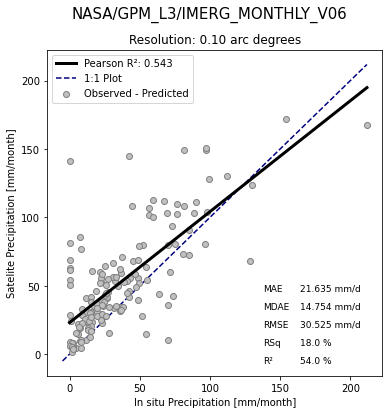

<Figure size 432x288 with 0 Axes>

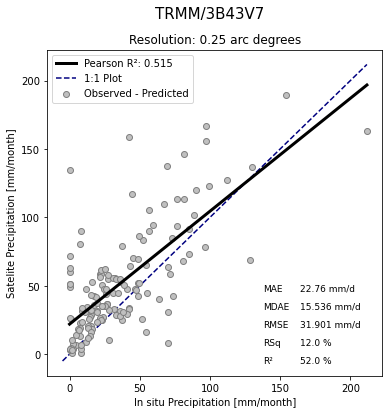

<Figure size 432x288 with 0 Axes>

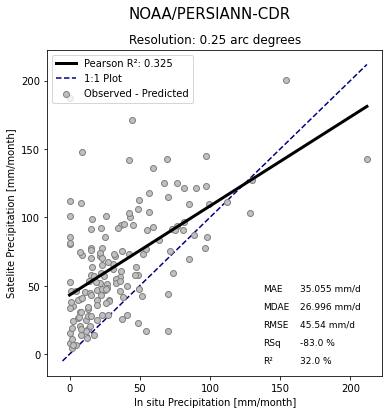

<Figure size 432x288 with 0 Axes>

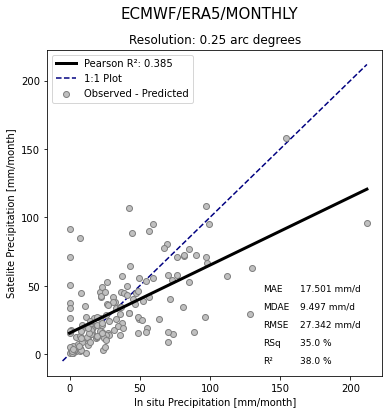

<Figure size 432x288 with 0 Axes>

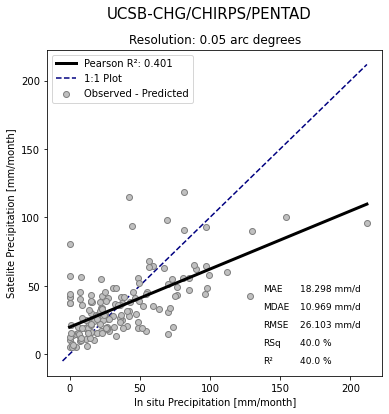

In [12]:
GPM_df = pd.merge(monthly['P'], GPM.resample('M').sum(), left_index=True, right_index=True)
GPM_df['Product'] = 'GPM'
GPM_df['precipitation'] = GPM_df['precipitation']*24*30
TRMM_df = pd.merge(monthly['P'], TRMM.resample('M').sum(), left_index=True, right_index=True)
TRMM_df['Product'] = 'TRMM {}'.format('1')
TRMM_df['precipitation'] = TRMM_df['precipitation']*24*30
ECMWF.columns = ['precipitation', 'Variance']
ECMWF_df = pd.merge(monthly['P'], ECMWF.resample('M').sum(), left_index=True, right_index=True)
ECMWF_df['Product'] = 'ECMWF'
ECMWF_df['precipitation'] = ECMWF_df['precipitation']*24*30
CHIRPS_df = pd.merge(monthly['P'], CHIRPS.resample('M').sum(), left_index=True, right_index=True)
CHIRPS_df['Product'] = 'CHIRPS'
PERSIANN = PERSIANN_A.append([PERSIANN_B, PERSIANN_C, PERSIANN_D, PERSIANN_E])
PERSIANN_df = pd.merge(monthly['P'], PERSIANN.resample('M').sum(), left_index=True, right_index=True)
PERSIANN_df['Product'] = 'PERSIANN'

plt.figure()
gpm = plot_regression(GPM_df['P'], GPM_df['precipitation'])
plt.suptitle('NASA/GPM_L3/IMERG_MONTHLY_V06', fontsize = 15)
plt.title('Resolution: 0.10 arc degrees', fontsize = 12)
plt.savefig('gpm.jpg')
plt.figure()
trmm = plot_regression(TRMM_df['P'], TRMM_df['precipitation'])
plt.suptitle('TRMM/3B43V7', fontsize = 15)
plt.title('Resolution: 0.25 arc degrees', fontsize = 12)
plt.savefig('trmm.jpg')
plt.figure()
persiann = plot_regression(PERSIANN_df['P'], PERSIANN_df['precipitation'])
plt.suptitle('NOAA/PERSIANN-CDR', fontsize = 15)
plt.title('Resolution: 0.25 arc degrees', fontsize = 12)
plt.savefig('persiann.jpg')
plt.figure()
ecmwf = plot_regression(ECMWF_df['P'], ECMWF_df['precipitation'])
plt.suptitle('ECMWF/ERA5/MONTHLY', fontsize = 15)
plt.title('Resolution: 0.25 arc degrees', fontsize = 12)
plt.savefig('ecmwf.jpg')
plt.figure()
chirps = plot_regression(CHIRPS_df['P'], CHIRPS_df['precipitation'])
plt.suptitle('UCSB-CHG/CHIRPS/PENTAD', fontsize = 15)
plt.title('Resolution: 0.05 arc degrees', fontsize = 12)
plt.savefig('chirps.jpg');

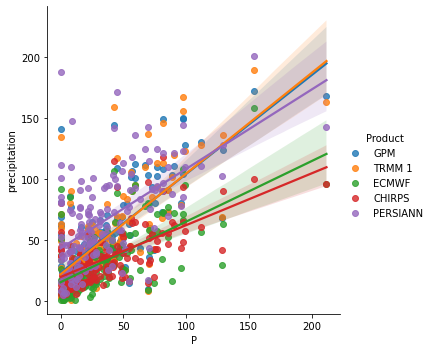

In [13]:
rainfall = GPM_df.append([TRMM_df, ECMWF_df, CHIRPS_df, PERSIANN_df])
sns.lmplot(x = 'P', y = 'precipitation', hue = 'Product', data = rainfall);

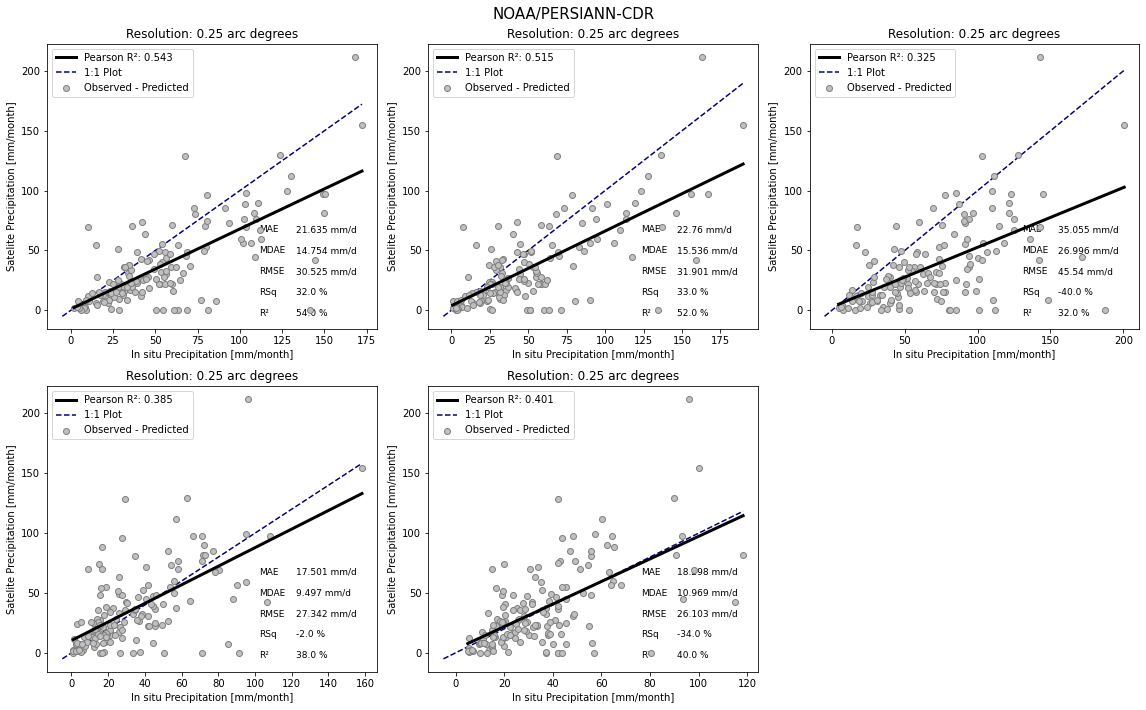

In [14]:
def plot_regression(O, P):
#     plt.figure(figsize = (6, 6))
#     plt.grid(zorder = 1)
    plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
    corr, _ = pearsonr(O, P)
    regmodel = LinearRegression()
    regmodel.fit(O.values.reshape(-1,1), P)
    rsq = regmodel.score(O.values.reshape(-1,1), P)
    obs, pred = O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1))
    plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
    plt.plot([-5, obs.max()], [-5, obs.max()], color = 'navy', ls = '--', zorder = 1)
    plt.legend([u'Pearson R\u00b2: {:.3f}'.format(corr**2), '1:1 Plot', 'Observed - Predicted'], loc = 2)
    plt.xlabel('In situ Precipitation [mm/month]')
    plt.ylabel('Satelite Precipitation [mm/month]')
    stats = np.round(metrics(O, P), 3)
    stats = pd.DataFrame(data = stats, index = ['MAE', 'MDAE', 'RMSE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
    stats.loc['RSq'] = np.round((stats.loc['RSq']) , 2) * 100
    stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']) , 2) * 100
    stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm/d' )
    stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
    stats = stats2.append(stats3)
    table = plt.table(cellText=stats.values, colWidths = [0.5]*len(stats.columns),
          rowLabels=stats.index,
#           colLabels=stats.columns,
          cellLoc = 'left', rowLoc = 'left',
          loc=4, edges='open')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(.5, 1.5)
#     return stats

models = [GPM_df['P'], TRMM_df['P'], PERSIANN_df['P'], ECMWF_df['P'], CHIRPS_df['P']]
observ = [GPM_df['precipitation'], TRMM_df['precipitation'], PERSIANN_df['precipitation'], ECMWF_df['precipitation'], CHIRPS_df['precipitation']]

num=0
for i in range(5):
    num += 1
    plt.gcf().set_size_inches(16, 10)
    plt.subplot(2, 3, num)
    plt.suptitle('NOAA/PERSIANN-CDR', fontsize = 15)
    plt.title('Resolution: 0.25 arc degrees', fontsize = 12)
    plot_regression(observ[i], models[i])

plt.tight_layout(pad=1.0)